In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os
import io
from PIL import Image

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [50]:
# %% Cell 2: Load and Inspect Raw Data
# First, let's just look at the raw CSV file
filepath = r'C:\Users\ejdes\Documents\Patrick\shotmarker data\SM_shotslog_Nov_09.csv'

with open(filepath, 'r') as f:
    lines = f.readlines()

print(f"Total lines in file: {len(lines)}")
print("\nFirst 10 lines:")
for i, line in enumerate(lines[:50]):
    print(f"{i}: {line.strip()}")

Total lines in file: 142

First 10 lines:
0: ShotMarker Archived Data (generated Nov 09 2025)
1: Exported 8 strings from Nov 09 of 43 total in archive
2: 
3: Nov 09 2025,Will prone slow,#66 (Delta),1080 x 1689,NRA MR-63 at 300y,176-5X,
4: ,time,tags,id,score,temp C,x mm,y mm,v fps,yaw deg, pitch deg,quality,xy_err
5: ,3:08.26 pm,sighter,S1,9,6,-8,-111,2026,-13.8,0.8,2.2,5.1,"sim_t(6,2994,5614,3507,970,2368,4993,2593,0);"
6: ,3:09.05 pm,sighter,S2,7,6,149,-142,2012,-14.3,1.4,5.4,3.8,"sim_t(6,5354,8440,4548,949,4751,7857,3675,0);"
7: ,3:09.42 pm,,1,7,6,-73,-150,2011,-14,0.7,2.9,5.5,"sim_t(6,2100,5625,4203,993,1462,4982,3271,0);"
8: ,3:10.36 pm,,2,X,6,-27,-20,2043,-13.9,1.4,2.9,4,"sim_t(6,2794,3575,1751,965,2146,2982,837,0);"
9: ,3:11.04 pm,,3,7,6,53,-158,1973,-14.2,1,4.5,4.3,"sim_t(6,4040,7522,4650,985,3412,6895,3734,0);"
10: ,3:11.29 pm,,4,8,6,-42,-113,2014,-13.7,1.6,3.7,5.1,"sim_t(6,2572,5427,3757,992,1917,4810,2845,0);"
11: ,3:12.18 pm,,5,X,6,37,-7,2026,-13.7,0.7,2.2,2.7,"sim_t(6,3571

In [51]:
# %% Cell 3: Define Parse Function
def parse_shotmarker_csv(filepath):
    """Parse the ShotMarker CSV file with multiple shooting strings."""
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    all_strings = []
    current_string = None
    current_data = []
    
    for line in lines:
        line = line.strip()
        
        if not line or line.startswith('ShotMarker') or line.startswith('Exported'):
            continue
            
        # Check if this is a new string header
        if line.startswith('Nov ') and ',' in line:
            parts = [p.strip() for p in line.split(',')]
            if len(parts) >= 6:
                # Save previous string
                if current_string and current_data:
                    df = pd.DataFrame(current_data)
                    current_string['data'] = df
                    all_strings.append(current_string)
                
                # Parse shooter and stage from parts[1]
                shooter_stage = parts[1] if parts[1] else ''
                tokens = shooter_stage.split()
                shooter = tokens[0] if tokens else ''
                stage = ' '.join(tokens[1:]) if len(tokens) > 1 else ''
                
                # Start new string
                current_string = {
                    'date': parts[0],
                    'shooter': shooter,
                    'stage': stage,
                    'rifle': parts[2],
                    'target_info': parts[3],
                    'course': parts[4],
                    'score': parts[5]
                }
                current_data = []
                continue
        
        if line.startswith(',time,'):
            continue
        
        if line.startswith(',') and current_string:
            parts = [p.strip() for p in line.split(',')]
            if len(parts) >= 13:
                try:
                    shot_data = {
                        'time': parts[1],
                        'tags': parts[2],
                        'id': parts[3],
                        'score': parts[4],
                        'temp_c': float(parts[5]) if parts[5] else None,
                        'x_mm': float(parts[6]) if parts[6] else None,
                        'y_mm': float(parts[7]) if parts[7] else None,
                        'v_fps': float(parts[8]) if parts[8] else None,
                        'yaw_deg': float(parts[9]) if parts[9] else None,
                        'pitch_deg': float(parts[10]) if parts[10] else None,
                        'quality': float(parts[11]) if parts[11] else None,
                        'xy_err': float(parts[12]) if parts[12] else None
                    }
                    current_data.append(shot_data)
                except (ValueError, IndexError):
                    continue
    
    # Add final string
    if current_string and current_data:
        df = pd.DataFrame(current_data)
        current_string['data'] = df
        all_strings.append(current_string)
    
    return all_strings

print("✓ Parse function defined")


✓ Parse function defined


In [52]:
# %% Cell 4: Parse the Data
shooting_strings = parse_shotmarker_csv(filepath)

print(f"Found {len(shooting_strings)} shooting strings\n")

Found 8 shooting strings



In [53]:
# Display summary of each string
for i, s in enumerate(shooting_strings):
    print(f"{i+1}. {s['shooter']} - {s['course']}")
    print(f"   Score: {s['score']}, Shots: {len(s['data'])}")

1. Will - NRA MR-63 at 300y
   Score: 176-5X, Shots: 22
2. Mark - NRA MR-63 at 300y
   Score: 199-11X, Shots: 22
3. Will - NRA SR-3 at 300y
   Score: 88-0X, Shots: 12
4. Mark - NRA SR-3 at 300y
   Score: 85-0X, Shots: 12
5. Will - NRA SR at 200y
   Score: 91-0X, Shots: 12
6. Mark - NRA SR at 200y
   Score: 94-2X, Shots: 12
7. Will - NRA SR at 200y
   Score: 86-0X, Shots: 12
8. Mark - NRA SR at 200y
   Score: 90-0X, Shots: 12


In [54]:
# %% Cell 5: Examine One String in Detail
# Let's look at the first shooting string
first_string = shooting_strings[0]

print("First shooting string details:")
print(f"Shooter: {first_string['shooter']}")
print(f"Course: {first_string['course']}")
print(f"Rifle: {first_string['rifle']}")
print(f"Score: {first_string['score']}")
print(f"\nShot data (first 5 rows):")
print(first_string['data'].head())

First shooting string details:
Shooter: Will
Course: NRA MR-63 at 300y
Rifle: #66 (Delta)
Score: 176-5X

Shot data (first 5 rows):
         time     tags  id score  temp_c   x_mm   y_mm   v_fps  yaw_deg  \
0  3:08.26 pm  sighter  S1     9     6.0   -8.0 -111.0  2026.0    -13.8   
1  3:09.05 pm  sighter  S2     7     6.0  149.0 -142.0  2012.0    -14.3   
2  3:09.42 pm            1     7     6.0  -73.0 -150.0  2011.0    -14.0   
3  3:10.36 pm            2     X     6.0  -27.0  -20.0  2043.0    -13.9   
4  3:11.04 pm            3     7     6.0   53.0 -158.0  1973.0    -14.2   

   pitch_deg  quality  xy_err  
0        0.8      2.2     5.1  
1        1.4      5.4     3.8  
2        0.7      2.9     5.5  
3        1.4      2.9     4.0  
4        1.0      4.5     4.3  


In [55]:
# %% Cell 6: Basic Statistics
# Calculate some basic stats for the first string
df = first_string['data']
shots = df[df['tags'] != 'sighter']

print(f"Total shots: {len(shots)}")
print(f"Sighters: {len(df[df['tags'] == 'sighter'])}")
print(f"\nX coordinate - Mean: {shots['x_mm'].mean():.1f}mm, SD: {shots['x_mm'].std():.1f}mm")
print(f"Y coordinate - Mean: {shots['y_mm'].mean():.1f}mm, SD: {shots['y_mm'].std():.1f}mm")

if len(shots) > 1:
    x_spread = shots['x_mm'].max() - shots['x_mm'].min()
    y_spread = shots['y_mm'].max() - shots['y_mm'].min()
    group_size = np.sqrt(x_spread**2 + y_spread**2)
    print(f"\nGroup size: {group_size:.1f}mm")

Total shots: 20
Sighters: 2

X coordinate - Mean: -20.1mm, SD: 64.1mm
Y coordinate - Mean: 10.8mm, SD: 90.8mm

Group size: 442.2mm


In [56]:
# %% Cell 7: Define Simple Plot Function
def plot_target_simple(string_data, target_size_mm=400):
    """Simple target plot for testing."""
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    df = string_data['data']
    sighters = df[df['tags'] == 'sighter']
    shots = df[df['tags'] != 'sighter']
    
    # Draw target rings
    for i, radius_fraction in enumerate([1.0, 0.8, 0.6, 0.4, 0.2]):
        radius = target_size_mm/2 * radius_fraction
        circle = Circle((0, 0), radius, fill=False, 
                       edgecolor='black', linewidth=1.5)
        ax.add_patch(circle)
    
    # X-ring
    x_ring = Circle((0, 0), target_size_mm/2 * 0.1, fill=False,
                   edgecolor='red', linewidth=2.5)
    ax.add_patch(x_ring)
    
    # Plot shots
    if len(shots) > 0:
        ax.scatter(shots['x_mm'], shots['y_mm'], 
                  c='blue', s=150, alpha=0.6, 
                  edgecolors='darkblue', linewidth=1.5, label='Shots', zorder=5)
        # label each shot id inside the marker
        for _, shot in shots.iterrows():
            ax.annotate(str(shot['id']), (shot['x_mm'], shot['y_mm']),
                        fontsize=9, ha='center', va='center',
                        color='white', weight='bold', zorder=6)
    
    if len(sighters) > 0:
        ax.scatter(sighters['x_mm'], sighters['y_mm'],
                  c='orange', s=150, alpha=0.7, marker='s',
                  edgecolors='darkorange', linewidth=1.5, label='Sighters', zorder=5)
        # label each sighter id inside the square marker
        for _, s in sighters.iterrows():
            ax.annotate(str(s['id']), (s['x_mm'], s['y_mm']),
                        fontsize=9, ha='center', va='center',
                        color='white', weight='bold', zorder=6)
    
    ax.set_aspect('equal')
    limit = target_size_mm / 2 * 1.1
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.set_title(f"{string_data['shooter']} - {string_data['course']}\nScore: {string_data['score']}")
    ax.legend()
    
    return fig, ax

print("✓ Simple plot function defined")

✓ Simple plot function defined


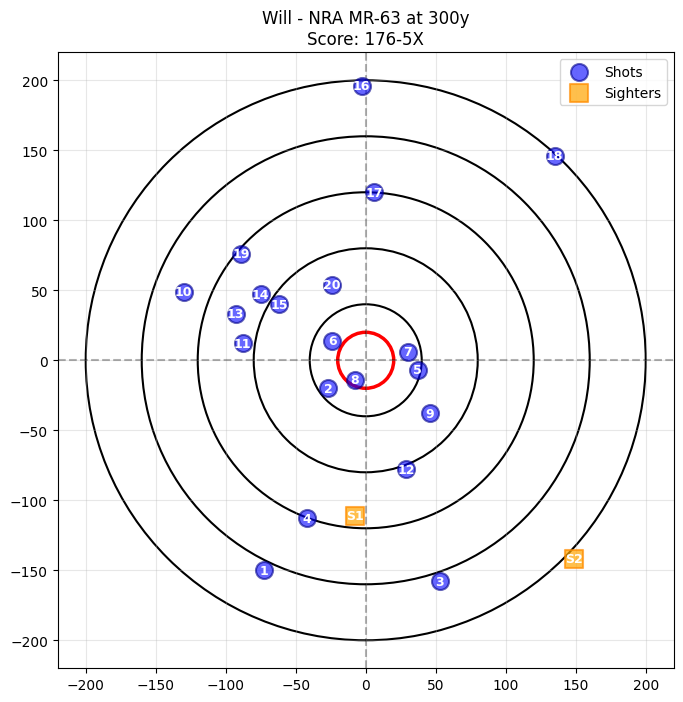

In [57]:
# %% Cell 8: Test Simple Plot
# Plot the first shooting string
fig, ax = plot_target_simple(first_string)
plt.show()


In [58]:
# %% Cell 9: Define Enhanced Plot Function with Labels
def plot_target_with_scores(string_data, target_size_mm=None):
    """Enhanced target plot with shot scores and calculated target size."""
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    df = string_data['data']
    sighters = df[df['tags'] == 'sighter']
    shots = df[df['tags'] != 'sighter']
    
    # Calculate target size based on farthest shots
    if target_size_mm is None:
        x_max = shots['x_mm'].abs().max() if len(shots) > 0 else 0
        y_max = shots['y_mm'].abs().max() if len(shots) > 0 else 0
        farthest = max(x_max, y_max)
        target_size_mm = (farthest * 2 + 25) // 50 * 50  # Round up to nearest 50mm and add 25mm
        if target_size_mm < 50:
            target_size_mm = 50
    
    # Draw target rings
    for radius_fraction in [1.0, 0.8, 0.6, 0.4, 0.2]:
        radius = target_size_mm/2 * radius_fraction
        circle = Circle((0, 0), radius, fill=False, 
                       edgecolor='black', linewidth=1.5, alpha=0.8)
        ax.add_patch(circle)
    
    # X-ring
    x_ring = Circle((0, 0), target_size_mm/2 * 0.1, fill=False,
                   edgecolor='red', linewidth=2.5)
    ax.add_patch(x_ring)
    
    # Plot shots with IDs inside markers
    if len(shots) > 0:
        ax.scatter(shots['x_mm'], shots['y_mm'], 
                  c='blue', s=150, alpha=0.6, 
                  edgecolors='darkblue', linewidth=2, label='Shots', zorder=5)
        
        for _, shot in shots.iterrows():
            ax.annotate(str(shot['id']), (shot['x_mm'], shot['y_mm']),
                       fontsize=8, ha='center', va='center',
                       color='white', weight='bold', zorder=6)
    
    # Plot sighters
    if len(sighters) > 0:
        ax.scatter(sighters['x_mm'], sighters['y_mm'],
                  c='orange', s=150, alpha=0.6,
                  edgecolors='darkorange', linewidth=2,
                  marker='s', label='Sighters', zorder=5)
        
        for _, shot in sighters.iterrows():
            label = f"{shot['id']}\n({shot['score']})"
            ax.annotate(label, (shot['x_mm'], shot['y_mm']),
                       fontsize=8, ha='center', va='center',
                       color='white', weight='bold')
    
    ax.set_aspect('equal')
    limit = target_size_mm / 2 * 1.1
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.set_xlabel('Horizontal (mm)')
    ax.set_ylabel('Vertical (mm)')
    
    title = f"{string_data['shooter']} - {string_data['course']}\n{string_data['rifle']}\nScore: {string_data['score']}\nTarget: {target_size_mm}mm"
    ax.set_title(title, fontsize=11, weight='bold')
    ax.legend()
    
    return fig, ax

print("✓ Enhanced plot function defined")


✓ Enhanced plot function defined


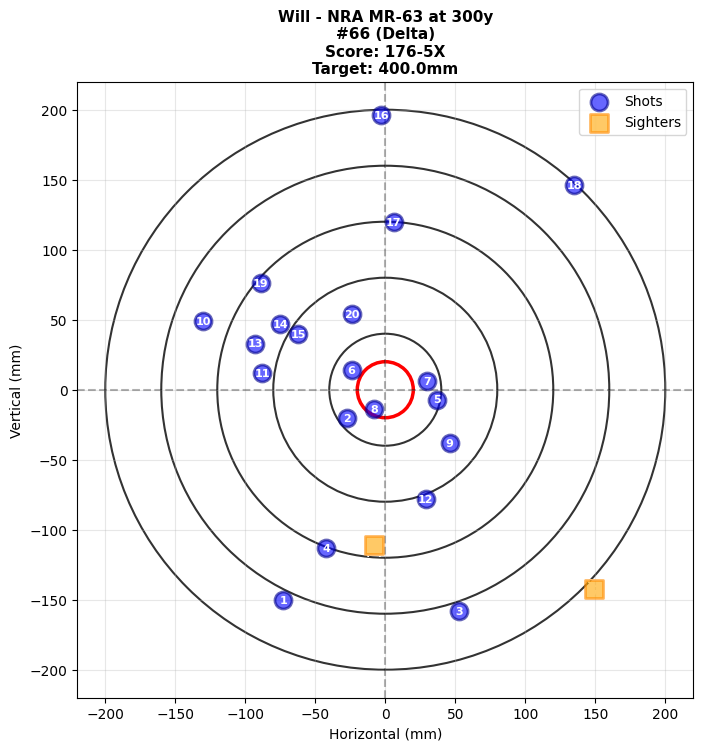

In [59]:
# %% Cell 10: Test Enhanced Plot
fig, ax = plot_target_with_scores(first_string)
plt.show()

In [60]:
# %% Cell 11: Group Data by Shooter
def group_by_shooter(shooting_strings):
    """Group shooting strings by shooter."""
    shooters = {}
    for string_data in shooting_strings:
        shooter = string_data['shooter']
        if shooter not in shooters:
            shooters[shooter] = []
        shooters[shooter].append(string_data)
    return shooters

shooters = group_by_shooter(shooting_strings)

print("Shooters found:")
for shooter, strings in shooters.items():
    print(f"\n{shooter}: {len(strings)} strings")
    for s in strings:
        print(f"  - {s['course']}: {s['score']}")

Shooters found:

Will: 4 strings
  - NRA MR-63 at 300y: 176-5X
  - NRA SR-3 at 300y: 88-0X
  - NRA SR at 200y: 91-0X
  - NRA SR at 200y: 86-0X

Mark: 4 strings
  - NRA MR-63 at 300y: 199-11X
  - NRA SR-3 at 300y: 85-0X
  - NRA SR at 200y: 94-2X
  - NRA SR at 200y: 90-0X


In [61]:
# %% Cell 12: Calculate Totals
def calculate_totals(shooters):
    """Calculate total scores for each shooter."""
    totals = {}
    
    for shooter, strings in shooters.items():
        total_score = 0
        total_x = 0
        
        for string_data in strings:
            score_str = string_data['score']
            score_parts = score_str.split('-')
            points = int(score_parts[0]) if score_parts[0] else 0
            x_count = int(score_parts[1].replace('X', '')) if len(score_parts) > 1 and score_parts[1] else 0
            
            total_score += points
            total_x += x_count
        
        totals[shooter] = {'score': total_score, 'x_count': total_x}
    
    return totals

totals = calculate_totals(shooters)

print("\nTotal Scores:")
print("="*40)
for shooter, data in totals.items():
    print(f"{shooter}: {data['score']}-{data['x_count']}X")


Total Scores:
Will: 441-5X
Mark: 468-13X


Plotting all targets for Will...


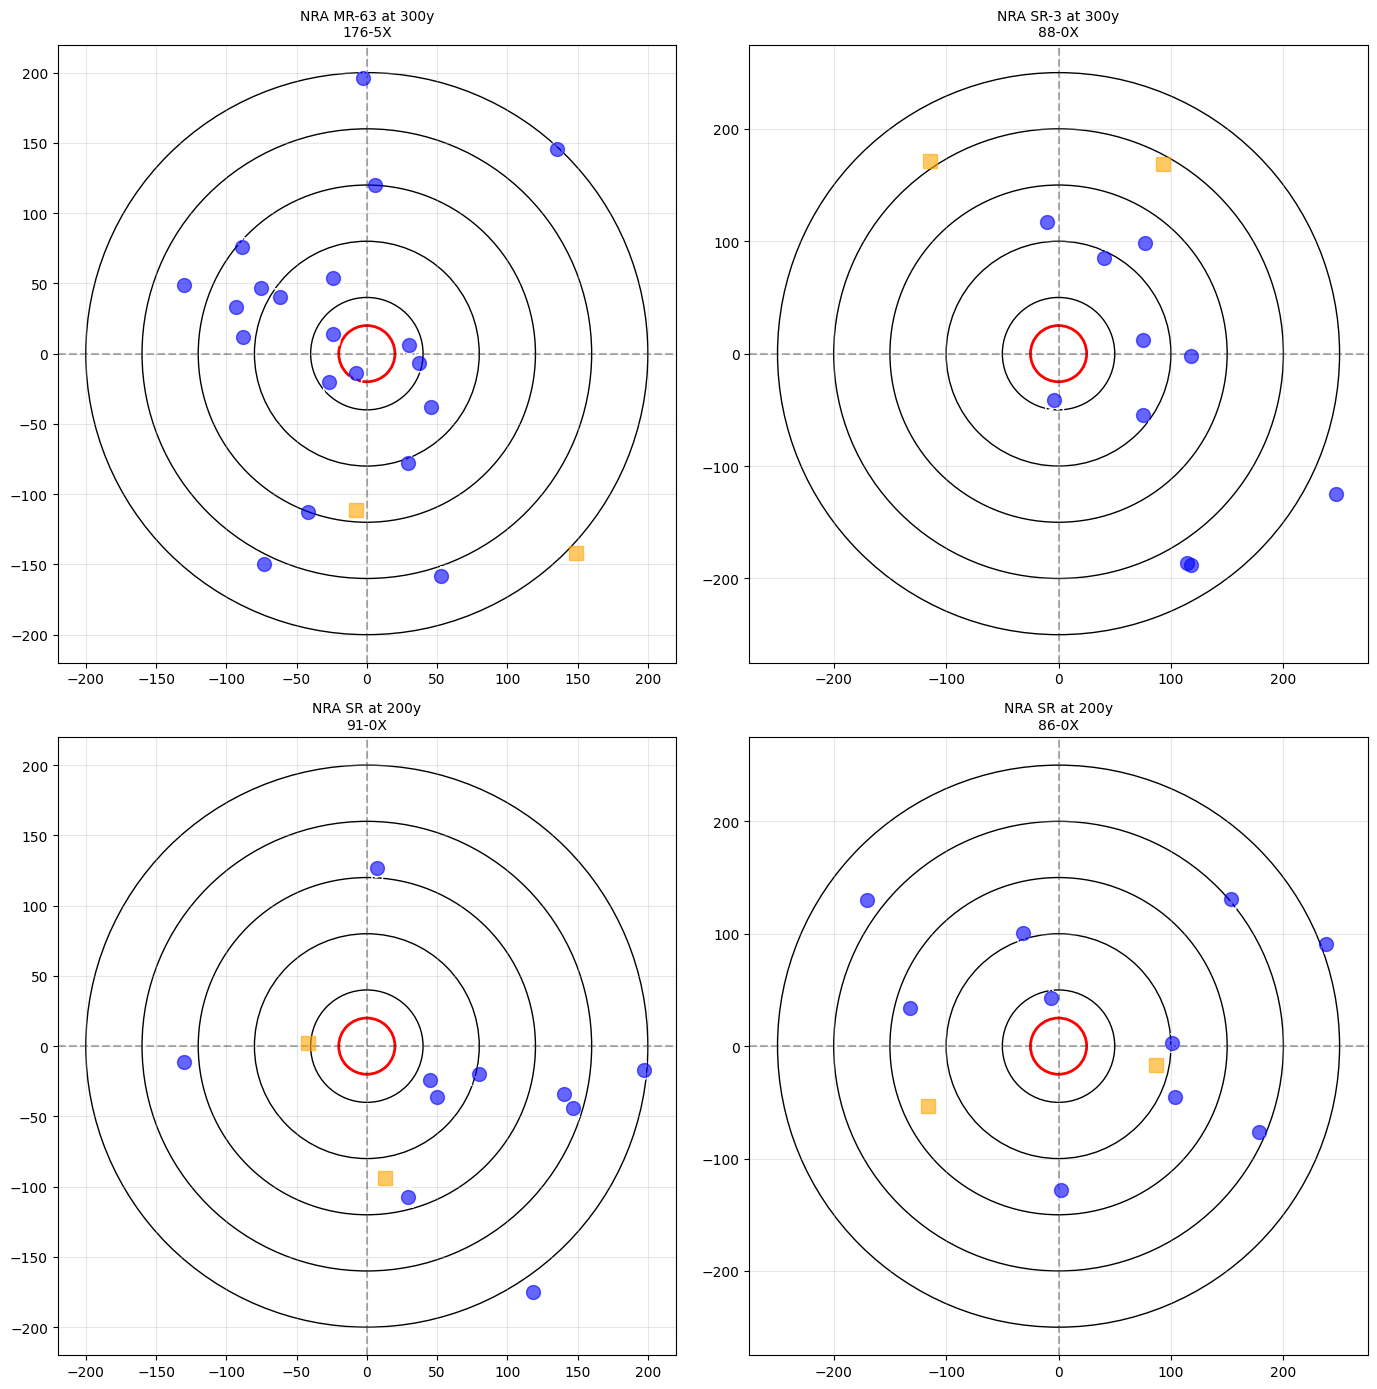

In [62]:
# %% Cell 13: Plot All Targets for One Shooter
# Plot all strings for the first shooter
first_shooter = list(shooters.keys())[0]
shooter_strings = shooters[first_shooter]

print(f"Plotting all targets for {first_shooter}...")

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, string_data in enumerate(shooter_strings[:4]):
    ax = axes[idx]
    
    df = string_data['data']
    sighters = df[df['tags'] == 'sighter']
    shots = df[df['tags'] != 'sighter']
    
    # Draw target
    x_max = shots['x_mm'].abs().max() if len(shots) > 0 else 0
    y_max = shots['y_mm'].abs().max() if len(shots) > 0 else 0
    farthest = max(x_max, y_max)
    target_size_mm = (farthest * 2 + 25) // 50 * 50
    if target_size_mm < 50:
        target_size_mm = 50
    for radius_fraction in [1.0, 0.8, 0.6, 0.4, 0.2]:
        radius = target_size_mm/2 * radius_fraction
        circle = Circle((0, 0), radius, fill=False, 
                       edgecolor='black', linewidth=1)
        ax.add_patch(circle)
    
    x_ring = Circle((0, 0), target_size_mm/2 * 0.1, fill=False,
                   edgecolor='red', linewidth=2)
    ax.add_patch(x_ring)
    
    # Plot shots
    if len(shots) > 0:
        ax.scatter(shots['x_mm'], shots['y_mm'], 
                  c='blue', s=100, alpha=0.6, zorder=5)
        for _, shot in shots.iterrows():
            ax.annotate(f"{shot['id']}\n({shot['score']})",
                       (shot['x_mm'], shot['y_mm']),
                       fontsize=7, ha='center', va='center',
                       color='white', weight='bold')
    
    if len(sighters) > 0:
        ax.scatter(sighters['x_mm'], sighters['y_mm'],
                  c='orange', s=100, alpha=0.6, marker='s', zorder=5)
    
    ax.set_aspect('equal')
    limit = target_size_mm / 2 * 1.1
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.set_title(f"{string_data['course']}\n{string_data['score']}", fontsize=10)

plt.tight_layout()
plt.show()

In [63]:
# %% Cell 14: Save Individual Images
def save_target_images(shooting_strings, output_dir='target_images'):
    """Save individual PNG images."""
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for string_data in shooting_strings:
        shooter = string_data['shooter'].replace(' ', '_')
        course = string_data['course'].replace('/', '_').replace(' ', '_')
        filename = f"{shooter}_{course}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig, ax = plot_target_with_scores(string_data)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved: {filename}")

# Uncomment to save images:
save_target_images(shooting_strings)
print("✓ Save function defined (uncomment to use)")


Saved: Will_NRA_MR-63_at_300y.png
Saved: Mark_NRA_MR-63_at_300y.png
Saved: Will_NRA_SR-3_at_300y.png
Saved: Mark_NRA_SR-3_at_300y.png
Saved: Will_NRA_SR_at_200y.png
Saved: Mark_NRA_SR_at_200y.png
Saved: Will_NRA_SR_at_200y.png
Saved: Mark_NRA_SR_at_200y.png
✓ Save function defined (uncomment to use)


In [64]:
# %% Cell 15: Create PDF Report
def create_pdf_report(shooting_strings, output_filename='shooting_report.pdf'):

    
    shooters = group_by_shooter(shooting_strings)
    totals_dict = calculate_totals(shooters)
    
    # Order totals by highest score
    sorted_totals = sorted(totals_dict.items(), key=lambda kv: kv[1]['score'], reverse=True)
    
    with PdfPages(output_filename) as pdf:
        # Front page: standings
        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis('off')
        ax.set_title('Competition Results — Standings', fontsize=18, weight='bold', pad=20)
        
        header = "Rank  Shooter      Score (X)"
        ax.text(0.02, 0.86, header, fontsize=12, family='monospace')
        
        y = 0.82
        for rank, (shooter, data) in enumerate(sorted_totals, start=1):
            line = f"{rank:>2}.   {shooter:<12}  {data['score']}-{data['x_count']}X"
            ax.text(0.02, y, line, fontsize=12, family='monospace')
            y -= 0.04
        
        # add generation footer
        ax.text(0.02, 0.06, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", fontsize=9, color='gray')
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close(fig)
        
        # One page per shooter: place all their target images onto a single page
        for shooter, strings in shooters.items():
            n = len(strings)
            if n == 0:
                continue
            # layout: square-ish grid
            ncols = int(np.ceil(np.sqrt(n)))
            nrows = int(np.ceil(n / ncols))
            # use a higher base DPI for the page to improve embedded image resolution
            page_dpi = 200
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), dpi=page_dpi)
            # normalize axes to iterable list
            if isinstance(axes, np.ndarray):
                axes_flat = axes.flatten()
            else:
                axes_flat = [axes]
            
            for ax_idx, ax_slot in enumerate(axes_flat):
                ax_slot.axis('off')
            
            for i, string_data in enumerate(strings):
                # render individual target into a buffer using existing plot function
                tmp_fig, tmp_ax = plot_target_with_scores(string_data)
                buf = io.BytesIO()
                # Save at very high DPI to reduce blurriness when embedding
                tmp_fig.savefig(buf, dpi=600, bbox_inches='tight', pad_inches=0.1, format='png', transparent=True)
                plt.close(tmp_fig)
                buf.seek(0)
                
                # Open and composite onto white background to avoid transparency artifacts
                im = Image.open(buf).convert("RGBA")
                bg = Image.new("RGBA", im.size, (255, 255, 255, 255))
                im = Image.alpha_composite(bg, im)
                arr = np.asarray(im.convert("RGB"))
                buf.close()
                
                ax_slot = axes_flat[i]
                # Display with nearest interpolation to avoid smoothing that makes text blurry
                ax_slot.imshow(arr, interpolation='nearest')
                ax_slot.axis('off')
                # set a compact title overlay (shooter is same for this page)
                ax_slot.set_title(f"{string_data['course']} — {string_data['score']}", fontsize=9, pad=4)
            
            # Hide any unused axes
            for j in range(len(strings), len(axes_flat)):
                axes_flat[j].axis('off')
            
            # Save the shooter's page at a decent DPI
            plt.tight_layout()
            pdf.savefig(fig, bbox_inches='tight', dpi=300)
            plt.close(fig)
        
        # Add metadata
        d = pdf.infodict()
        d['Title'] = 'Shooting Performance Report'
        d['Author'] = 'ShotMarker Analysis'
        d['CreationDate'] = datetime.now()
    
    print(f"PDF saved as: {output_filename}")

# Uncomment to create PDF:
create_pdf_report(shooting_strings)
print("✓ PDF function defined (uncomment to use)")

PDF saved as: shooting_report.pdf
✓ PDF function defined (uncomment to use)
